# Module 3 – Classification

This material is adapted from the book Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow by Geron Aurelien.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# And now, let's get started with classification

Previously, we looked at regression -- predicting values.

Now we will look at classification -- predicting classes.

For example:
* detecting spam / not-spam
* determining the type of flower based on sepal and petal width and length
* labeling people in photographs
* recognizing digits


# MNIST

MNIST is a dataset of 70,000 images of handwritten numbers from 0 to 9.

MNIST is a very popular dataset for learning about and testing ML algorithms.

We can use the scikit-learn helper function `fetch_openml` to download a copy of the MNIST dataset.


**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

#### Structure of scikit-learn datasets

Dictionary with:
* DESCR key that has a description of the dataset
* data key that has an array with one row per instance and one column per feature
* target key with the labels

For the MNIST dataset:
* There are 70,000 images of handwritten digits 0 to 9
* Each image is 28x28 pixels
* Each image has 784 features (28x28)
* Each feature represents one pixel's intensity from 0 (white) to 255 (black)

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

In [ ]:
y.shape

In [ ]:
28 * 28

To visualize one of the digits, we can reshape the 784 feature values into a 28x28 array and then use imshow() to display it:

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [ ]:
y[0]

In [ ]:
y = y.astype(np.uint8)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
y[0]

Here is a sample of the digits to see what we are working with:

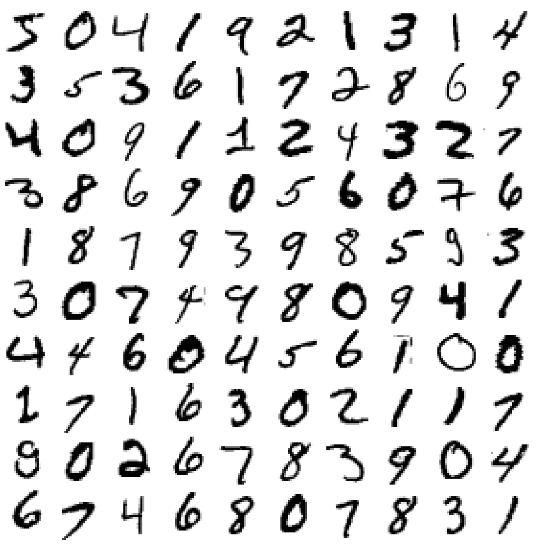




### Wait!  Create a training and testing set

Before we look at the data too much, we should create testing and training sets.

MNIST is already split into a training set (the first 60,000 images) and a testing set (the last 10,000).

In addition, the training set is already shuffled for us!


In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Our ultimate goal will be to classify any digit.

To start, we will try to just recognize fives.

To do this, we need new labels:

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
y_test_5

For this classificaiton problem, we will try using a Stochastic Gradient Descent (SGD) classifier.

SGD classifiers work well with large datasets.

We will learn more about how SGD classifiers work in detail later in the course.

For now, we will use SGDClassifier to create a "5-detector" -- a binary classifier that will return True if it predicts the image to be a five, and will return False otherwise.


**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

In [ ]:
sgd_clf.predict([some_digit])

# Performance Measures

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

It looks like we got above 95% accuracy on all the cross-validation folds.

This is pretty good, right?


## Measuring Accuracy Using Cross-Validation

#### Consider a "dumb" classifier that always returns "not-5"

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # np.zeros returns an array of zeros of size len(X) by 1
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Wow!  This "dumb" classifier got over 90% accuracy.

Why is that?

For classifiers, often we will want to look at measures other than just accuracy.

We will start by looking at a confusion matrix.


**Warning**: this output (and many others in this notebook and other notebooks) may differ slightly from those in the book. Don't worry, that's okay! There are several reasons for this:
* first, Scikit-Learn and other libraries evolve, and algorithms get tweaked a bit, which may change the exact result you get. If you use the latest Scikit-Learn version (and in general, you really should), you probably won't be using the exact same version I used when I wrote the book or this notebook, hence the difference. I try to keep this notebook reasonably up to date, but I can't change the numbers on the pages in your copy of the book.
* second, many training algorithms are stochastic, meaning they rely on randomness. In principle, it's possible to get consistent outputs from a random number generator by setting the seed from which it generates the pseudo-random numbers (which is why you will see `random_state=42` or `np.random.seed(42)` pretty often). However, sometimes this does not suffice due to the other factors listed here.
* third, if the training algorithm runs across multiple threads (as do some algorithms implemented in C) or across multiple processes (e.g., when using the `n_jobs` argument), then the precise order in which operations will run is not always guaranteed, and thus the exact result may vary slightly.
* lastly, other things may prevent perfect reproducibility, such as Python dicts and sets whose order is not guaranteed to be stable across sessions, or the order of files in a directory which is also not guaranteed.

## Confusion Matrix

A confusion matrix provides a way to see more closely what is going on.

For a binary classifier, there are four situations:
* true positive -- the image was actually a 5, and the classifier predicted it to be a 5
* false positive -- the image was not actually a 5, but the classifier predicted it to be a 5
* false negative -- the image was actually a 5, but the classifier predicted it to not be a 5
* true negative -- the image was not actually a 5, and the classifier predicted it to not be a 5


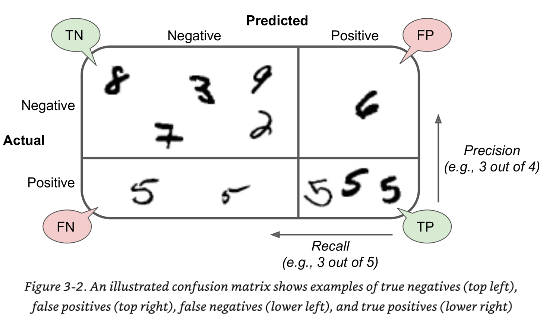




Let's look at the confusion matrix for our SGD "5-detector":

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

In [ ]:
y_train_pred

In the output, the rows are the actual class and the columns are the predicted class.

This means that our "5-detector" had:

The first row considers the non-5 images (the negative class):
* 53,892 true negatives
* 687 false positives

The second row considers the images of 5s (the positive class):
* 1,891  false negatives
* 3,530 true positives

A "perfect" classifier would have non-zero values only on the main diagonal:


In [ ]:
confusion_matrix(y_train_5, y_train_5)

## Precision and Recall

Precision: accuracy of the positive predictions
* Of the things we predicted to be 5s, what percent did we get right?

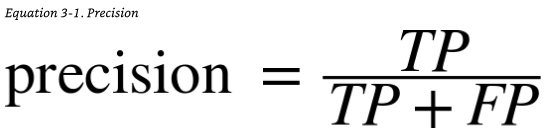


Recall:
* Of all the actual 5s, what percent did we predict to be 5s?

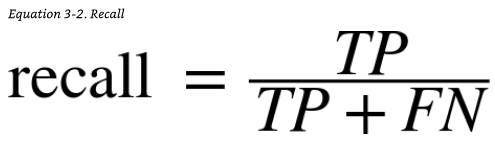



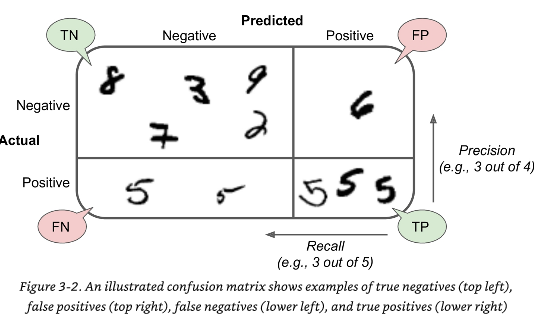


scikit-learn has functions to compute precision and recall:


In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

In [ ]:
recall_score(y_train_5, y_train_pred)

### F<sub>1</sub> score

Sometimes precision and recall are combined into a single metric called the F<sub>1</sub> score.

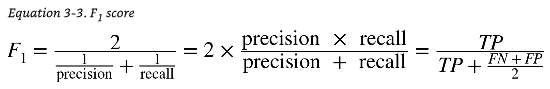

The F<sub>1</sub> score is the harmonic mean of precision and recall.

The harmonic mean gives more weight to low values.

This means that a classifier will get a high F<sub>1</sub> score if both recall and precision are high.

We can compute it using the scikit-learn function f1_score:


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

## Precision/Recall Trade-off

There is a built-in trade-off between precision and recall.

Sometimes you may want a classifier to have high recall.

For example, if you have built a classifier to detect dangerous amounts of a chemical in soil, you probably want high recall.
*  in other words, you probably don't want to mis-classify dangerous soil as being safe
*  you would probably rather have some false positives (some safe soil is marked as dangerous and needs follow-up testing)

Othertimes you may want a classifier to have high precision.

For example, suppose we have a "spam-detector" that predicts whether an email is spam (positive) or not spam (negative).

```
                                           predicted
                              
                         |   not spam (neg)    |   spam (pos)   |
                         | ------------------- | -------------- |
                         |        TN           |     FP         |    ^
          not spam (neg) |    from: mom        |   from: mom    |    |
actual                   | ------------------- | -------------- |    |
          spam (pos)     |        FN           |     TP         |    |
                         |  from:make$fast     | from:make$fast |    precision = TP / (TP + FP)
                          --------------------- ----------------
                                         <------ recall = TP / (TP + FN)
```

In this example:
* a false negative means we are incorrectly letting an actual spam message through to our inbox
    * e.g., we end up with a message from "make$fast" in our inbox

* a false positive means we are incorrectly putting a non-spam message into our spam folder
    * e.g., an important message from our mom ends up in our spam folder

Assuming that we think the cost of having a non-spam message go to our spam folder is higher than the cost of having to delete a spam message that got through to our inbox:

* We should prefer precision over recall
    * in other words, if the classifier labels the message as spam, we really want it to actually be spam (high precision)
    * we are willing to have some of the actual spam messages get through to our inbox (lower recall)


#### Precision/Recall trade-off

As mentioned earlier, there is a built-in trade-off between precision and recall.

For example, our SGDClassifier computes a score for each instance and if the score is greater than a decision threashold, it classifies it to the positive class.  Otherwise, it assigns it to the negative class.

Here is an illustration from the book:

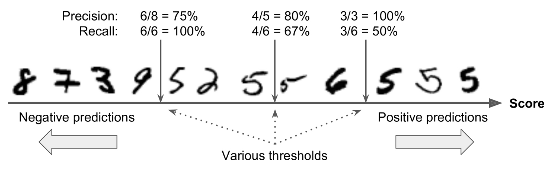

If you raise the threshold (arrow to the right), then:
* precision increases
* recall decreases

If you lower the threshold (arrow to the left), then:
* precision decreases
* recall increases


#### decsion_function()

We cannot directly change the threshold of the classifier.

However, we can get access to the scores from the SGDClassifier's decision_function()

Below, we will get the (one) score for some_digit.

Recall that `some_digit=X[0]` and it is a five.


In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

The `SGDClassifier` uses a threshold of 0

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

We could manually use a different value:

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

The question is:  how do we know what value to use for the threshold?

To start, we will use the `decision_function` method of cross_val_predict to get the decision scores (instead of the predictions).

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
y_scores

In [ ]:
y_scores.shape

Now, we can use scikit-learn's `precision_recall_curve()` function to compute precision and recall for all possible thresholds:


In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

And then we can plot these using Matplotlib:

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

#### Plot precision directly against recall

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

Let's find out what threshold we would need to use to get 90% precision:

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

So we could then use that threshold

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

And check our precision and recall scores

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

## The ROC Curve

The receiver operating characteristic (ROC) curve is another tool we can use with binary classifiers.

It is similar to the PR curve, but instead, it plots recall (true positive rate) versus false positive rate (FPR).

FPR is the ratio of negative instances that are incorrectly classified as positive.


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

Again, we see the trade-off.

The higher the recall, the more false positives we get.

The dotted line shows the ROC curve for a purely random classifier.

A good classifier stays as far away from the dotted line as possible (toward the top left).


#### Area under the curve (AUC)

One way to compare classifiers is to compare the amount of area under the ROC curve.

A perfect classifier would have AUC=1

A purely random classifier would have AUC=0.5

We can use scikit-learn's `roc_auc_socre` function to compute this metric:


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

#### Compare two classifiers

Let's train a `RandomForestClassifier` and compare its ROC curve and AUC score to those of the SGDClassifier.

The `RandomForestClassifier` does not have a `decision_function()` method, but instead has a `predict_proba()` method.

`predict_proba()` returns an array with one row per instance and one column per class, each with the probability that the instance belongs to the given class.

We can use these probabilities in place of the scores in an ROC curve.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

The plot above illustrates how the Random Forest curve is better than the SGD classifier.

The AUC score is also better:

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

We can also look at the precision and recall scores for the Random Forest and see that it performs well.


In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)